# Installing packages and defining functions

In [ ]:
!pip install --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-0wbi606t/polara_e681326482164eda96ae68214decd15a
  Running command git clone --filter=blob:none --quiet https://github.com/evfro/polara.git /tmp/pip-install-0wbi606t/polara_e681326482164eda96ae68214decd15a
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit 8e48cfd88e616ca53f8bbda1702a3e2c8abaf38e
  Preparing metadata (setup.py) ... done
  Created wheel for polara: filename=polara-0.7.2.dev0-py3-none-any.whl size=89447 sha256=09d3e7879083ee8a8c82317c93b56fc905a7e4593f24d98147258d5ed1312a2f
  Stored in directory: /tmp/pip-ephem-wheel-cache-pmqws7zv/wheels/3f/3a/1f/42058978e585b23c384652846b96b72870f3c8c12976cdac50
Successfully built polara


In [ ]:
from typing import Optional, Union
from scipy.sparse import csr_matrix
import pandas as pd


def leave_last_out(data, userid='userid', timeid='timestamp'):
    data_sorted = data.sort_values('timestamp')
    holdout = data_sorted.drop_duplicates(
        subset=['userid'], keep='last'
    ) # split the last item from each user's history
    remaining = data.drop(holdout.index) # store the remaining data - will be our training
    return remaining, holdout


def transform_indices(data: pd.DataFrame, users: str, items:str, inplace: bool=False):
    data_index = {}
    data_codes = {}
    for entity, field in zip(['users', 'items'], [users, items]):
        new_index, data_index[entity] = to_numeric_id(data, field)
        if inplace:
            data.loc[:, field] = new_index
        else:
            data_codes[field] = new_index

    if data_codes:
        data = data.assign(**data_codes) # makes a copy of data
    return data, data_index


def to_numeric_id(data, field):
    idx_data = data[field].astype("category")
    idx = idx_data.cat.codes
    idx_map = idx_data.cat.categories.rename(field)
    return idx, idx_map


def reindex_data(
        data: pd.DataFrame,
        data_index: dict,
        entities: Optional[Union[str, list[str]]] = None,
        filter_invalid: bool = True,
        inplace: bool = False
    ):
    if entities is None:
        entities = data_index.keys()
    if isinstance(entities, str): # handle single entity provided as a string
        entities = [entities]

    data_codes = {}
    for entity in entities:
        entity_index = data_index[entity]
        field = entity_index.name # extract the field name
        new_index = entity_index.get_indexer(data[field])
        if inplace:
            data.loc[:, field] = new_index # assign new values inplace
        else:
            data_codes[field] = new_index # store new values

    if data_codes:
        data = data.assign(**data_codes) # assign new values by making a copy

    if filter_invalid: # discard unrecognized entity index
        valid_values = [f'{data_index[entity].name}>=0' for entity in entities]
        data = data.query(' and '.join(valid_values))
    return data


def generate_interactions_matrix(data, data_description, rebase_users=False):
    n_users = data_description['n_users']
    n_items = data_description['n_items']
    # get indices of observed data
    user_idx = data[data_description['users']].values
    if rebase_users: # handle non-contiguous index of test users
        # This ensures that all user ids are contiguous and start from 0,
        # which helps ensure data consistency at the scoring stage.
        user_idx, user_index = pd.factorize(user_idx, sort=True)
        n_users = len(user_index)
    item_idx = data[data_description['items']].values
    feedback = data[data_description['feedback']].values
    # construct rating matrix
    return csr_matrix((feedback, (user_idx, item_idx)), shape=(n_users, n_items))


def verify_time_split(before, after, target_field='userid', timeid='timestamp'):
    '''
    Check that items from `after` dataframe have later timestamps than
    any corresponding item from the `before` dataframe. Compare w.r.t target_field.
    Usage example: assert that for any user, the holdout items are the most recent ones.
    '''
    before_ts = before.groupby(target_field)[timeid].max()
    after_ts = after.groupby(target_field)[timeid].min()
    assert (
        before_ts
        .reindex(after_ts.index)
        .combine(after_ts, lambda x, y: True if x!=x else x <= y)
    ).all()

In [ ]:
from polara import get_movielens_data
import pandas as pd

import scipy
from scipy import sparse as sp
import numpy as np
from scipy.sparse.linalg import svds, LinearOperator

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import euclidean

sns.set_style('darkgrid')

In [ ]:
def downvote_seen_items(scores, data, data_description):
    assert isinstance(scores, np.ndarray), 'Scores must be a dense numpy array!'
    itemid = data_description['items']
    userid = data_description['users']
    # get indices of observed data, corresponding to scores array
    # we need to provide correct mapping of rows in scores array into
    # the corresponding user index (which is assumed to be sorted)
    row_idx, test_users = pd.factorize(data[userid], sort=True)
    assert len(test_users) == scores.shape[0]
    col_idx = data[itemid].values
    # downvote scores at the corresponding positions
    scores[row_idx, col_idx] = scores.min() - 1


def topn_recommendations(scores, topn=10):
    recommendations = np.apply_along_axis(topidx, 1, scores, topn)
    return recommendations


def topidx(a, topn):
    parted = np.argpartition(a, -topn)[-topn:]
    return parted[np.argsort(-a[parted])]


def model_evaluate(recommended_items, holdout, holdout_description, topn=10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_items.shape[0] == len(holdout_items)
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    # coverage calculation
    n_items = holdout_description['n_items']
    cov = np.unique(recommended_items).size / n_items
    return hr, mrr, cov

In [ ]:
def get_M(matrix, i, j, q):
    '''
    Returns M(i, j) from the paper
    '''
    return matrix[i * q: (i + 1) * q, j * q: (j + 1) * q] #(i - 1) * q: i * q

# test get_M:
A_ = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
B = np.array([[1, 2],
              [3, 4]])
C = np.kron(A_, B)
C

array([[ 1,  2,  2,  4,  3,  6],
       [ 3,  4,  6,  8,  9, 12],
       [ 4,  8,  5, 10,  6, 12],
       [12, 16, 15, 20, 18, 24],
       [ 7, 14,  8, 16,  9, 18],
       [21, 28, 24, 32, 27, 36]])

In [ ]:
get_M(C, 0, 1, 2)

array([[2, 4],
       [6, 8]])

In [ ]:
get_M(C, 1, 1, 3)

array([[20, 18, 24],
       [16,  9, 18],
       [32, 27, 36]])

In [ ]:
def vec(M, n_rows, n_cols):
    '''
    Returns vectorized version of matrix M (concatenates columns of M into column vector)
    '''
    return sp.vstack([M.getcol(j).reshape((n_rows, 1)) for j in range(n_cols)])

# test vec:
# A_ = np.array([[1, 0, 0, 1],
#                [0, 0, 1, 0],
#                [5, 3, 1, 9]])
# vec(sp.csr_matrix(A_), 3, 4).A

In [ ]:
def permutation_operator(M, p, q):
    '''
    Implements permutation operator of matrix M from the paper, i.e.
    (i - 1)p + j row of M is set equal to vec(M(j, j))^T
    '''
    R = sp.vstack([vec(get_M(M, i, j, q), q, q).T for i in range(p) for j in range(p)])
    return R

# test permutation operator:
C_ = sp.csr_matrix(C)
C_perm = permutation_operator(C_, 3, 2)
C_perm.A

array([[ 1,  3,  2,  4],
       [ 2,  6,  4,  8],
       [ 3,  9,  6, 12],
       [ 4, 12,  8, 16],
       [ 5, 15, 10, 20],
       [ 6, 18, 12, 24],
       [ 7, 21, 14, 28],
       [ 8, 24, 16, 32],
       [ 9, 27, 18, 36]])

In [ ]:
def get_block(row, q):
    return row.reshape((q, q)).T

def inverse_permutation_operator(M, p, q):
    '''
    Implements inverse permutation operator for matrix M
    '''
    P = np.hstack([get_block(M[0 * p + j, :], q) for j in range(p)])
    for i in range(1, p):
        row_block = np.hstack([get_block(M[i * p + j, :], q) for j in range(p)])
        P = np.vstack([P, row_block])
    return P

#test inverse_permutation_operator:
C_ = inverse_permutation_operator(C_perm.A, 3, 2)
C_

array([[ 1,  2,  2,  4,  3,  6],
       [ 3,  4,  6,  8,  9, 12],
       [ 4,  8,  5, 10,  6, 12],
       [12, 16, 15, 20, 18, 24],
       [ 7, 14,  8, 16,  9, 18],
       [21, 28, 24, 32, 27, 36]])

In [74]:
def max_(x, lambda_):
    return max(0, x - lambda_ / 2)

def find_solution(p, q, S, lambda_):
    '''
    Finds solution of the optimization problem (5) with the formula (7) for lambda = lambda_
    '''
    R_hat = permutation_operator(S, p, q)
    solution = np.zeros((p**2, q**2))
    k = max(1, min(p**2, q**2)-1)
    u, s, vh = sp.linalg.svds(R_hat, k=k)
    for i in range(k):
        solution += (max_(s[i], lambda_) * u[:, i]).reshape(p**2, 1) @ vh[i, :].reshape(1, q**2)
    return solution

In [73]:
def get_all_divisors(n):
    for i in range(1, int(n / 2) + 1):
        if n % i == 0:
            yield i
    yield n


def find_possible_pq(d):
    divisors = list(get_all_divisors(d))
    possible_pq = list()
    for i in range(len(divisors) // 2):
        possible_pq.append((divisors[i], divisors[-i - 1]))
    return possible_pq

# Data preparation

In [ ]:
data = get_movielens_data(include_time=True)
data.head()

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
#outlayers extraction:
data = data[data.userid != 46] #45
data = data[data.userid != 1812]
data = data[data.userid != 1]
data = data[data.userid != 1]

In [ ]:
training_, holdout_ = leave_last_out(data, 'userid', 'timestamp')
verify_time_split(training_, holdout_)

In [ ]:
training, data_index = transform_indices(training_, 'userid', 'movieid')
holdout = reindex_data(holdout_, data_index, filter_invalid=True).sort_values('userid')

In [ ]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    test_users = holdout[data_index['users'].name].values
)

In [ ]:
userid = data_description['users']
seen_idx_mask = training[userid].isin(data_description['test_users'])
testset = training[seen_idx_mask]

# Model evaluation

## PureSVD

In [ ]:
def build_svd_model(config, data, data_description):
    source_matrix = generate_interactions_matrix(data, data_description, rebase_users=False)
    _, s, vt = svds(
        source_matrix.astype('f8'),
        k=config['rank'],
        return_singular_vectors='vh'
    )
    sidx = np.argsort(-s)
    singular_values = s[sidx]
    item_factors = np.ascontiguousarray(vt[sidx, :].T)
    return item_factors, singular_values

In [ ]:
def svd_model_scoring(params, data, data_description):
    item_factors, sigma = params
    test_matrix = generate_interactions_matrix(data, data_description, rebase_users=True)
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

In [ ]:
V, sigma = svd_params = build_svd_model({'rank': 200}, training, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)

downvote_seen_items(svd_scores, testset, data_description)
svd_recs = topn_recommendations(svd_scores, topn=10)

hr, mrr, coverage = model_evaluate(svd_recs, holdout, data_description)
print(f"hit rate = {hr}, mrr = {mrr}, cov = {coverage}")

hit rate = 0.0828225940036442, mrr = 0.028933613089650857, cov = 0.37688984881209503


## PRLS

In [77]:
A = generate_interactions_matrix(training, data_description, rebase_users=True)

n_items = 3704 # count of items
n_users = 6040 - 3 # count of users
possible_pq = find_possible_pq(n_users + n_items)
possible_pq

[(1, 9741), (3, 3247), (17, 573), (51, 191)]

In [78]:
lambda_ = 5
p, q = possible_pq[-1]

S1 = sp.hstack([np.zeros((n_items, n_items)), A.T])
S2 = sp.hstack([A, np.zeros((n_users, n_users))])
S = sp.csr_matrix(sp.vstack([S1, S2]))

solution_test = find_solution(p, q, S, lambda_)
sigma_hat_lambda_test = inverse_permutation_operator(solution_test, p, q)

our_scores = sigma_hat_lambda_test[n_items:, :n_items]
downvote_seen_items(our_scores, testset, data_description)

recoms = topn_recommendations(our_scores)

hr, mrr, coverage = model_evaluate(recoms, holdout, data_description)
print(f"d = {d}")
print(f"p = {p}, q = {q} \nhit rate = {hr}, mrr = {mrr}, cov = {coverage}")


d = -1.0
p = 51, q = 191 
hit rate = 0.03876097399370548, mrr = 0.013819738596117593, cov = 0.18412526997840173


## Regularized PRLS

In [ ]:
A_hat_tests = []
recoms_tests = []
hrs = []
mrrs = []
covs = []
ds = np.linspace(-1, 1, 20)
lambda_ = 100
p, q = possible_pq[-1]
for d in ds:
    A_coefs = []
    for i in range(A.shape[1]):
        A_coefs.append(euclidean(A[:, i].A[:, 0], np.zeros(A.shape[0]))**(d - 1))
    A_coefs = np.array(A_coefs)
    A_reg = sp.csr_matrix(A @ np.diag(A_coefs))
    assert A.shape == A_reg.shape

    S1 = sp.hstack([np.zeros((n_items, n_items)), A_reg.T])
    S2 = sp.hstack([A_reg, np.zeros((n_users, n_users))])
    S = sp.csr_matrix(sp.vstack([S1, S2]))
    solution_test = find_solution(p, q, S, lambda_)
    sigma_hat_lambda_test = inverse_permutation_operator(solution_test, p, q)
    our_scores = sigma_hat_lambda_test[n_items:, :n_items]
    downvote_seen_items(our_scores, testset, data_description)
    A_hat_tests.append(our_scores)

    recoms = topn_recommendations(our_scores)
    recoms_tests.append(recoms)

    hr, mrr, coverage = model_evaluate(recoms, holdout, data_description)
    print(f"d = {d}")
    print(f"p = {p}, q = {q} \nhit rate = {hr}, mrr = {mrr}, cov = {coverage}")
    hrs.append(hr)
    mrrs.append(mrr)
    covs.append(coverage)

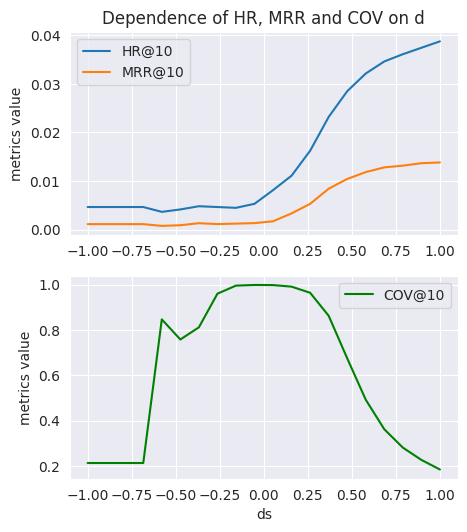

In [71]:
#these metrics were observed during the experiments:
hrs = [0.0046380, 0.0046380, 0.00463806, 0.0046380, 0.0036441941,
       0.004141129, 0.0048037, 0.0046380, 0.0044724200, 0.00530064,
       0.008116614212357131, 0.011098227596488323, 0.016233228424714263, 0.023190326321020374, 0.028490972337253603,
       0.03213516647341395, 0.03461984429352327, 0.03611065098558887, 0.037435812489647176, 0.03876097399370548]
mrrs = [0.001115,  0.0011157, 0.00111573, 0.0011157, 0.000752239,
        0.000892117, 0.0013070194, 0.0011230349, 0.00122130, 0.0013224664831423154,
        0.0017020700389923514, 0.003329665475598886, 0.0052924294890503275, 0.008404915718150769, 0.01042296052648877,
        0.011833639645466713, 0.012808448430446111, 0.013156237593043954, 0.013661981274205887, 0.013819738596117593]
covs = [0.2127429,0.21274298, 0.2127429, 0.212742980, 0.846922246,
        0.758099352, 0.81182505, 0.96031317494, 0.9959503, 0.9989200863930886,
        0.9983801295896328, 0.9913606911447084, 0.9643628509719222, 0.8628509719222462, 0.6749460043196545,
        0.492170626349892, 0.3617710583153348, 0.28077753779697623, 0.226511879049676, 0.18412526997840173]

f, axs = plt.subplots(2, figsize=(5, 5.8))
axs[0].plot(ds, hrs, label="HR@10")
axs[0].plot(ds, mrrs, label="MRR@10")
axs[0].set_ylabel("metrics value")
axs[0].legend()

axs[1].plot(ds, covs, label="COV@10", c='g')
axs[1].set_xlabel("ds")
axs[1].set_ylabel("metrics value")
axs[1].legend()

axs[0].set_title("Dependence of HR, MRR and COV on d")
plt.show()


## Searching of nuclear penalization coefficient lambda

In [ ]:
lambdas_ = [0, 0.1, 0.2, 0.3, 0.5, 1, 3, 10, 30, 40, 50, 60, 70, 100, 200, 300]
d = 0.85
p, q = possible_pq[-1]
A_hat_tests = []
recoms_tests = []
hrs = []
mrrs = []
covs = []
for lambda_ in lambdas_:
    A_coefs = []
    for i in range(A.shape[1]):
        A_coefs.append(euclidean(A[:, i].A[:, 0], np.zeros(A.shape[0]))**(d - 1))
    A_coefs = np.array(A_coefs)
    A_reg = sp.csr_matrix(A @ np.diag(A_coefs))
    assert A.shape == A_reg.shape

    S1 = sp.hstack([np.zeros((n_items, n_items)), A_reg.T])
    S2 = sp.hstack([A_reg, np.zeros((n_users, n_users))])
    S = sp.csr_matrix(sp.vstack([S1, S2]))

    solution_test = find_solution(p, q, S, lambda_)
    sigma_hat_lambda_test = inverse_permutation_operator(solution_test, p, q)
    our_scores = sigma_hat_lambda_test[n_items:, :n_items]
    downvote_seen_items(our_scores, testset, data_description)
    A_hat_tests.append(our_scores)

    recoms = topn_recommendations(our_scores)
    recoms_tests.append(recoms)

    hr, mrr, coverage = model_evaluate(recoms, holdout, data_description)
    print(f"lambda = {lambda_}")
    print(f"p = {p}, q = {q} \nhit rate = {hr}, mrr = {mrr}, cov = {coverage}")
    hrs.append(hr)
    mrrs.append(mrr)
    covs.append(coverage)

In [ ]:
A_coefs = []
lambdas_ = [0, 0.1, 0.2, 0.3, 0.5, 1, 3, 10, 30, 40, 50, 60, 70, 100, 200, 300]
d = 0.85
p, q = possible_pq[-1]
for i in range(A.shape[1]):
    A_coefs.append(euclidean(A[:, i].A[:, 0], np.zeros(A.shape[0]))**(d - 1))
A_coefs = np.array(A_coefs)
A_reg = sp.csr_matrix(A @ np.diag(A_coefs))
assert A.shape == A_reg.shape

S1 = sp.hstack([np.zeros((n_items, n_items)), A_reg.T])
S2 = sp.hstack([A_reg, np.zeros((n_users, n_users))])
S = sp.csr_matrix(sp.vstack([S1, S2]))
R_hat = permutation_operator(S, p, q)
k = max(1, min(p**2, q**2)-1)
u, s, vh = sp.linalg.svds(R_hat, k=k)

In [ ]:
lens = []
last_mins = []
for l in lambdas_:
    lens.append(len(s[s <= l / 2]) / len(s))
    last_mins.append(s[s > l / 2].min())

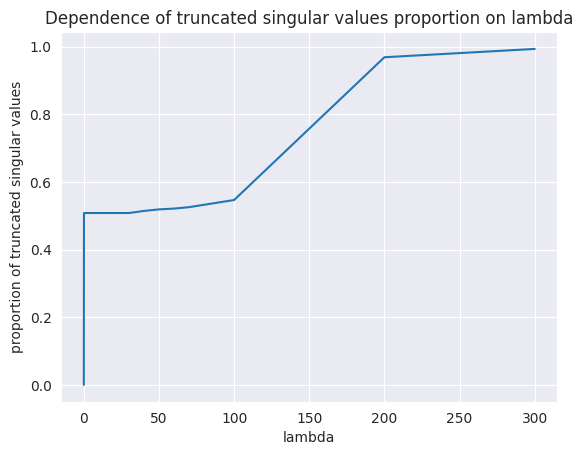

In [ ]:
plt.plot(lambdas_, lens)
plt.title("Dependence of truncated singular values proportion on lambda")
plt.xlabel("lambda")
plt.ylabel("proportion of truncated singular values")
plt.show()

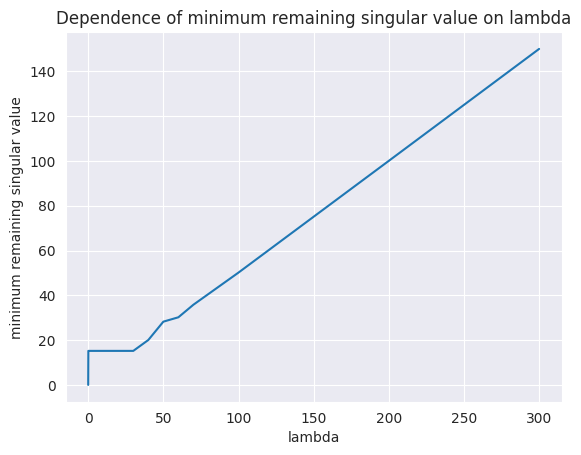

In [ ]:
plt.plot(lambdas_, last_mins)
plt.title("Dependence of minimum remaining singular value on lambda")
plt.xlabel("lambda")
plt.ylabel("minimum remaining singular value")
plt.show()

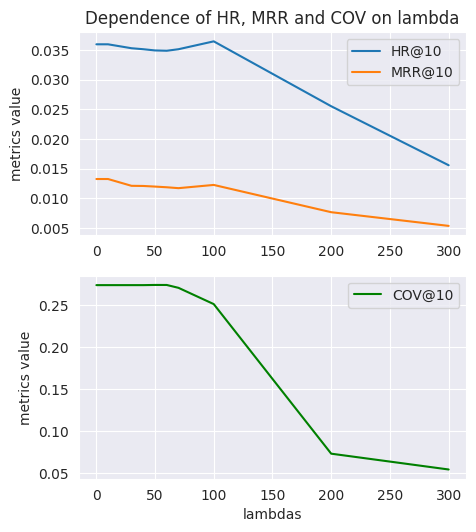

In [ ]:
#lambdas_ = [0, 0.1, 0.2, 0.3, 0.5, 1, 3, 10, 30, 40, 50, 60, 70, 100, 200, 300]
#from the experiments the next metrics were calculated:
hrs = [0.00447, 0.035945, 0.035945, 0.035945, 0.035945, 0.035945, 0.035945, 0.035945, 0.0352824, 0.0351167798, 0.034911, 0.034857, 0.035116, 0.0364419, 0.025509, 0.01557]
mrrs = [0.00153, 0.01325, 0.01325, 0.01325, 0.01325, 0.01325, 0.01325, 0.01325, 0.01210406, 0.01207993, 0.0119753, 0.01186, 0.01171, 0.012254, 0.00766, 0.005353]
covs = [0.91766, 0.274298, 0.274298, 0.274298, 0.274298, 0.274298, 0.274298, 0.274298, 0.274298, 0.274298, 0.27451, 0.27448, 0.271058, 0.25162, 0.072894, 0.0539956]

f, axs = plt.subplots(2, figsize=(5, 5.8))

axs[0].plot(lambdas_[1:], hrs[1:], label="HR@10")
axs[0].plot(lambdas_[1:], mrrs[1:], label="MRR@10")
# axs[0].set_xlabel("ks")
axs[0].set_ylabel("metrics value")
axs[0].legend()

axs[1].plot(lambdas_[1:], covs[1:], label="COV@10", c='g')
axs[1].set_xlabel("lambda")
axs[1].set_ylabel("metrics value")
axs[1].legend()

axs[0].set_title("Dependence of HR, MRR and COV on lambda")
plt.show()

# plt.plot(lambdas_[1:], hrs[1:], label="HR@10")
# plt.plot(lambdas_[1:], mrrs[1:], label="MRR@10")
# plt.plot(lambdas_[1:], covs[1:], label="COV@10")
# plt.legend()
# plt.xlabel("lambda")
# plt.ylabel("metrics value")
# plt.title("Dependence of HR, MRR and COV on lambda")
# plt.show()

## Random walk based PRLS

In [ ]:
alpha = 100
A_hat_tests = []
recoms_tests = []
d = 0.8
lambda_ = 50
p, q = possible_pq[-1]
ks = [1, 3, 5, 7, 10, 13]
for K in ks:
    S1 = sp.hstack([np.zeros((n_items, n_items)), A.T])
    S2 = sp.hstack([A, np.zeros((n_users, n_users))])

    S = sp.csr_matrix(sp.vstack([S1, S2]))
    S = sp.csr_matrix(alpha * np.diag(1. / (S @ np.ones(S.shape[1]))) @ S)
    solution_test = find_solution(p, q, S, lambda_)
    sigma_hat_lambda_test = inverse_permutation_operator(solution_test, p, q)
    our_scores = np.linalg.matrix_power(sigma_hat_lambda_test, K)[n_items:, :n_items]
    downvote_seen_items(our_scores, testset, data_description)
    A_hat_tests.append(our_scores)

    recoms = topn_recommendations(our_scores)
    recoms_tests.append(recoms)

    hr, mrr, coverage = model_evaluate(recoms, holdout, data_description)
    print(f"k = {K}")
    print(f"p = {p}, q = {q} \nhit rate = {hr}, mrr = {mrr}, cov = {coverage}")

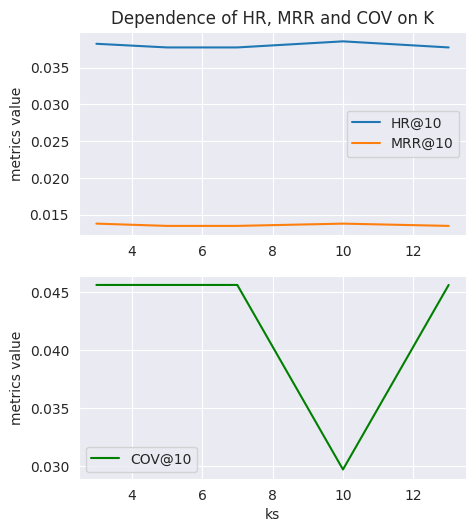

In [ ]:
#from the experiments it was observed:
hrs = [0.028325, 0.038264, 0.037767, 0.037767,0.038595, 0.037767]
mrrs = [0.009929, 0.013786, 0.013477, 0.0134777, 0.0137853, 0.013477]
covs = [0.76485, 0.045626, 0.045626, 0.045626, 0.029697, 0.045626]
f, axs = plt.subplots(2, figsize=(5, 5.8))

axs[0].plot(ks[1:], hrs[1:], label="HR@10")
axs[0].plot(ks[1:], mrrs[1:], label="MRR@10")
# axs[0].set_xlabel("ks")
axs[0].set_ylabel("metrics value")
axs[0].legend()

axs[1].plot(ks[1:], covs[1:], label="COV@10", c='g')
axs[1].set_xlabel("ks")
axs[1].set_ylabel("metrics value")
axs[1].legend()

axs[0].set_title("Dependence of HR, MRR and COV on K")
plt.show()

## Regularized random walk based PRLS

In [ ]:
A_hat_tests = []
recoms_tests = []
lambda_ = 50
for d in [0.7, 0.75, 0.8, 0.85]:
    for K in [8]:
        alpha = 10**(-int(K // 2))
        A_coefs = []
        for i in range(A.shape[1]):
            A_coefs.append(euclidean(A[:, i].A[:, 0], np.zeros(A.shape[0]))**(d - 1))
        A_coefs = np.array(A_coefs)
        A_reg = sp.csr_matrix(A @ np.diag(A_coefs))
        assert A.shape == A_reg.shape
        A_reg = A

        S1 = sp.hstack([np.zeros((n_items, n_items)), A_reg.T])
        S2 = sp.hstack([A_reg, np.zeros((n_users, n_users))])

        S = sp.csr_matrix(sp.vstack([S1, S2]))
        S = sp.csr_matrix(alpha * np.diag(1. / (S @ np.ones(S.shape[1]))) @ S)
        for p, q in [possible_pq[-1]]:
            solution_test = find_solution(p, q, S, lambda_)
            sigma_hat_lambda_test = inverse_permutation_operator(solution_test, p, q)
            our_scores = np.linalg.matrix_power(sigma_hat_lambda_test, K)[n_items:, :n_items]
            downvote_seen_items(our_scores, testset, data_description)
            A_hat_tests.append(our_scores)

            recoms = topn_recommendations(our_scores)
            recoms_tests.append(recoms)

            hr, mrr, coverage = model_evaluate(recoms, holdout, data_description)
            print(f"k = {K}, d = {d}")
            print(f"p = {p}, q = {q} \nhit rate = {hr}, mrr = {mrr}, cov = {coverage}")

[0.20628248 0.26064175 0.28030064 ... 0.3697973  0.37911272 0.27339491]
svd done
